In this second practical session, we will use `gudhi` to compute persistence diagrams of standard filtrations. We will first start with synthetic and intuitive examples, and then apply persistence on point clouds obtained from time series using time-delay embeddings.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import gudhi as gd

In [3]:
%matplotlib notebook

## 1.  Persistence Diagrams of standard spaces

### 1. Functions, cubical complex
#### Volcano
Let us first define a function from $\mathbb{R}^2 \to \mathbb{R}$.

<IPython.core.display.Javascript object>


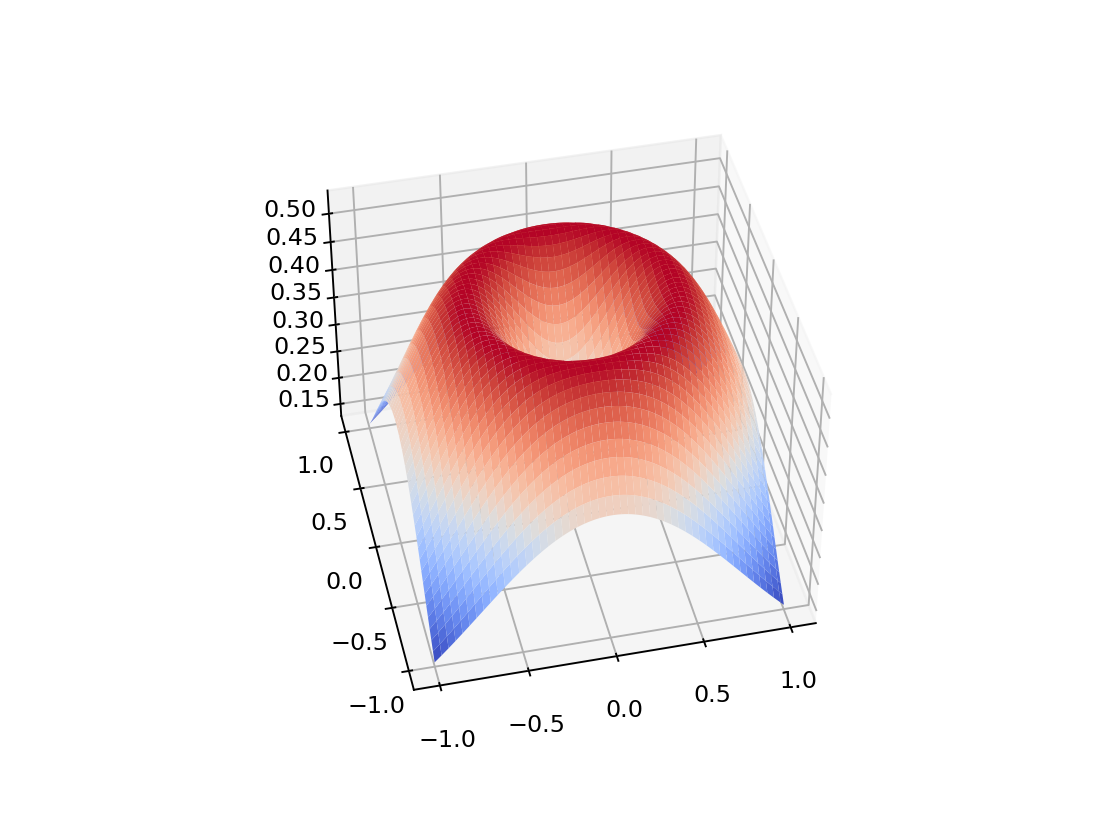

In [4]:
grid = np.linspace(-1,1,100)
gridx = grid[:,np.newaxis]
gridy = grid[np.newaxis,:]
sq = - gridx**2 - gridy**2
volcano = np.exp(sq) - 0.7 * np.exp(sq*4)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(gridx, gridy, volcano, cmap=matplotlib.cm.coolwarm)
plt.show()

Now that we have a function, build a filtered [cubical complex](https://gudhi.inria.fr/python/latest/cubical_complex_ref.html) from it and compute the persistence diagram of its **sub**levelsets. You should obtain the plots below.

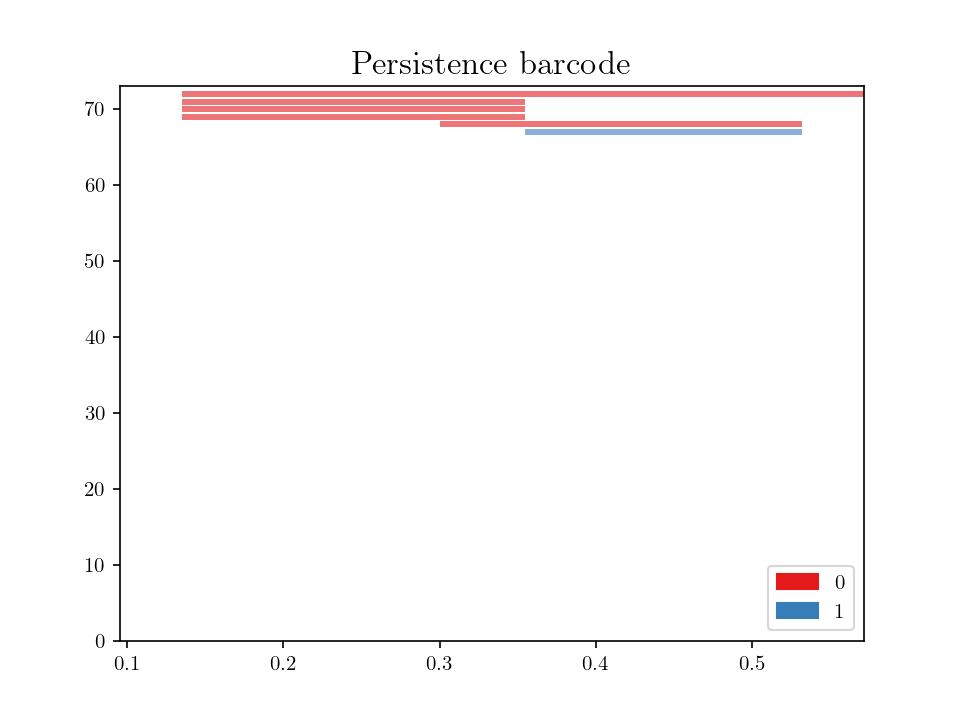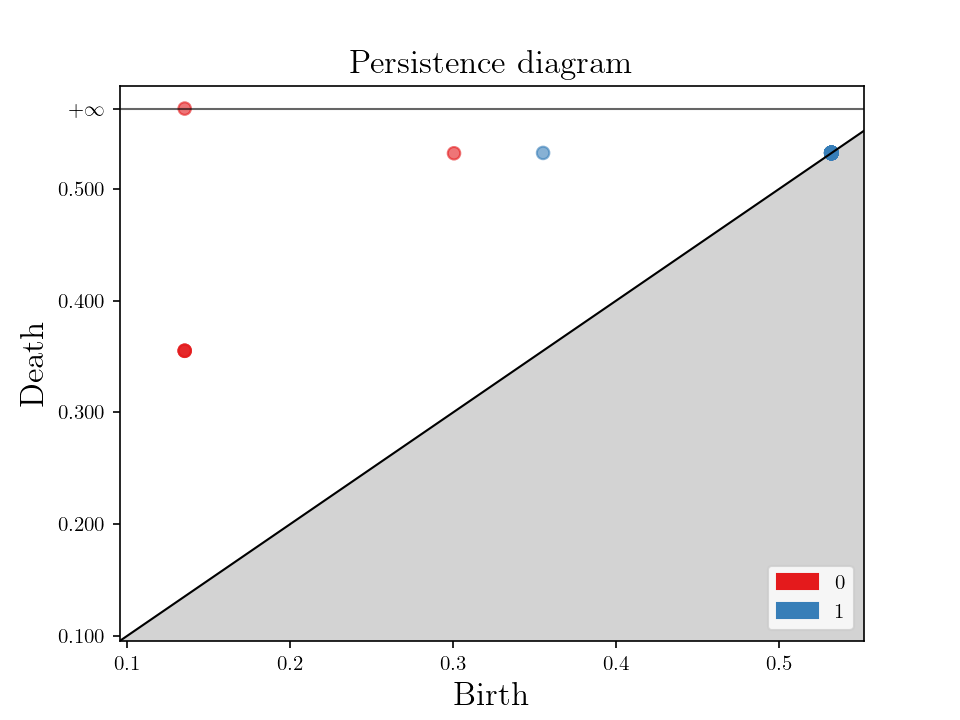

<IPython.core.display.Javascript object>


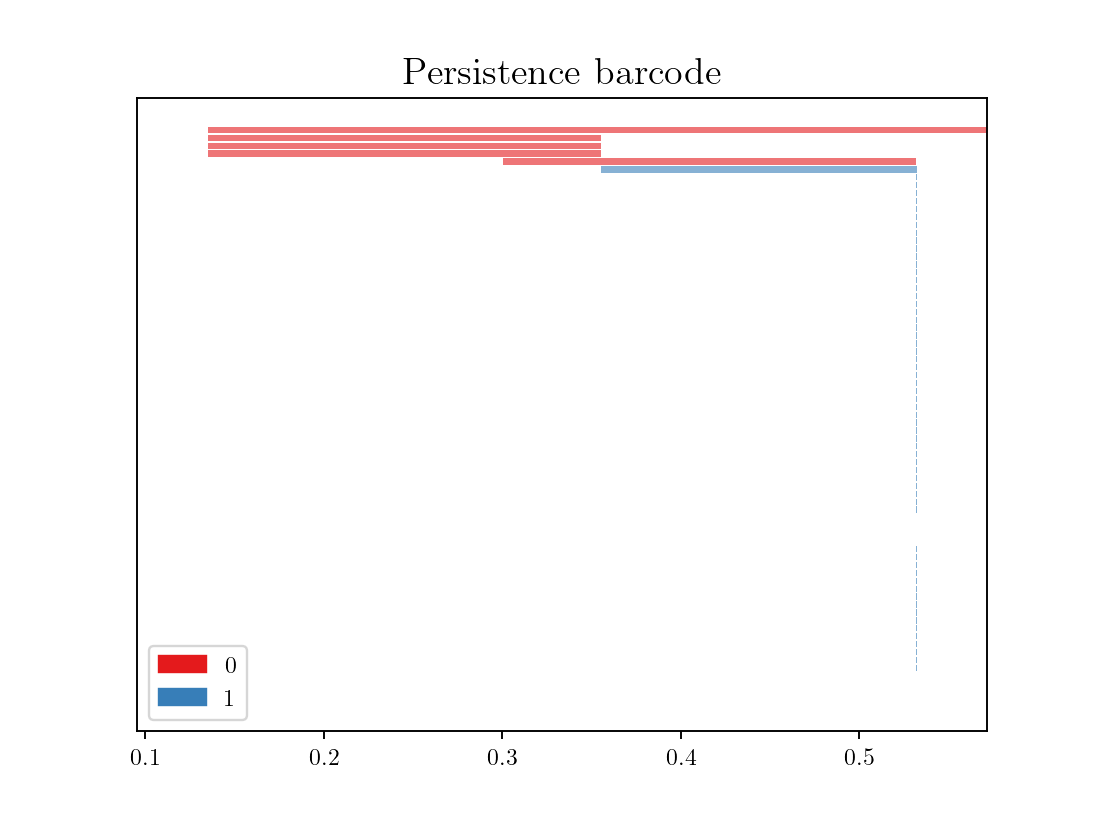

<IPython.core.display.Javascript object>


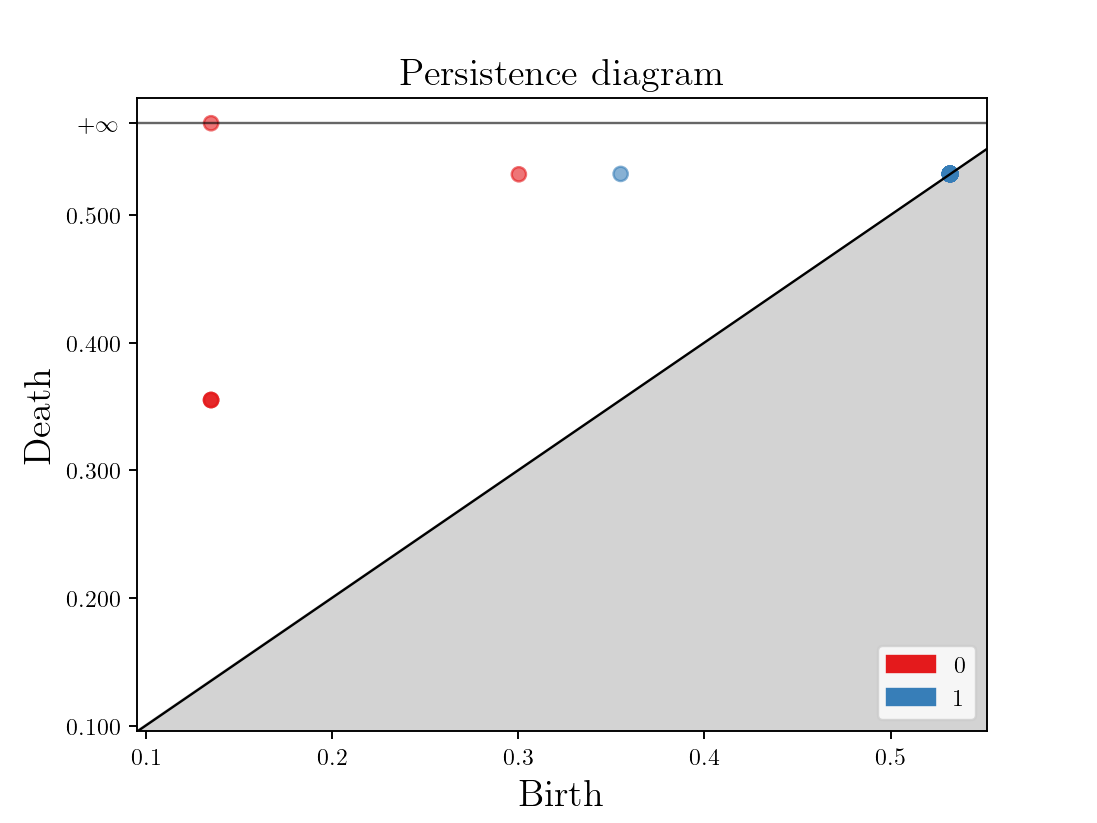

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [5]:
cplx = gd.CubicalComplex(top_dimensional_cells=volcano)
diag = cplx.persistence()
gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)
# red is dimension 0, blue is dimension 1

Compare the 2 plots. Why do we only see 3 red points but 5 red bars? Why are more than 60 of the bars invisible? You can print `diag` to help, the format is a list of `(dimension, (birth, death))`.

3 red bars are (almost) identical, so they show as a single red point with multiplicity 3. The invisible extra bars correspond to the blue point that is almost on the diagonal (so the bars are less than 1 pixel). The top of the volcano has many local maxima, and each generates a very short-lived hole.

Now compute the persistence diagram of the **super**levelsets of this function (hint: there is no direct function to that, only sublevelsets). You should obtain the plots below.

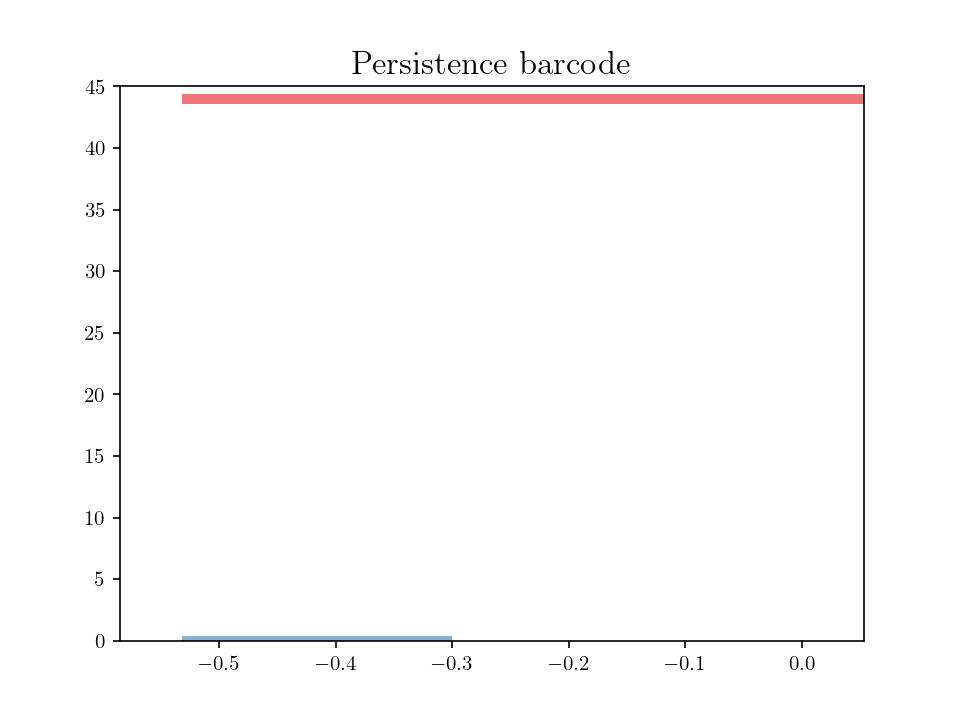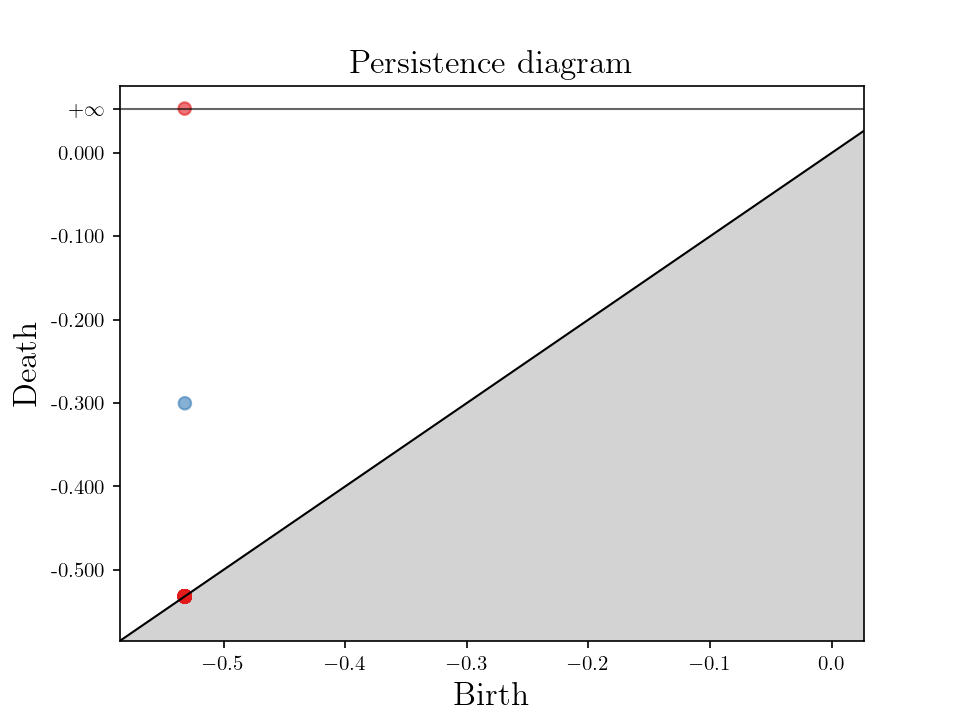

<IPython.core.display.Javascript object>


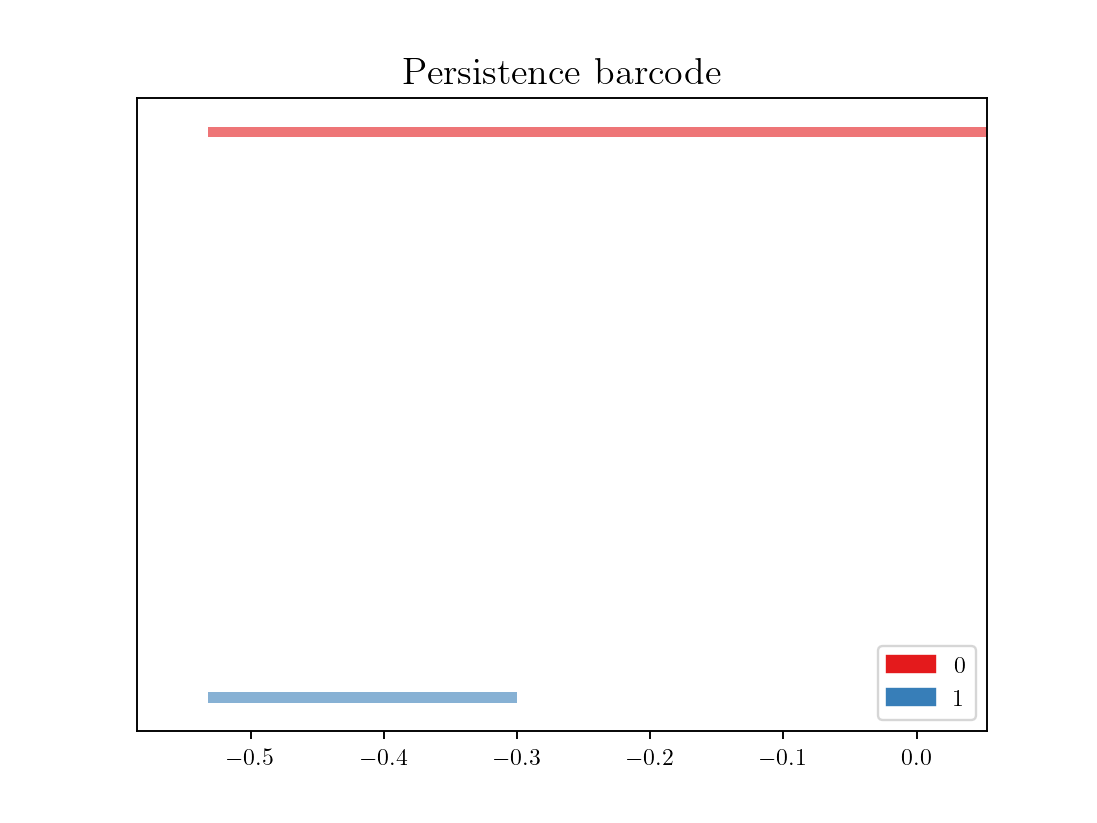

<IPython.core.display.Javascript object>


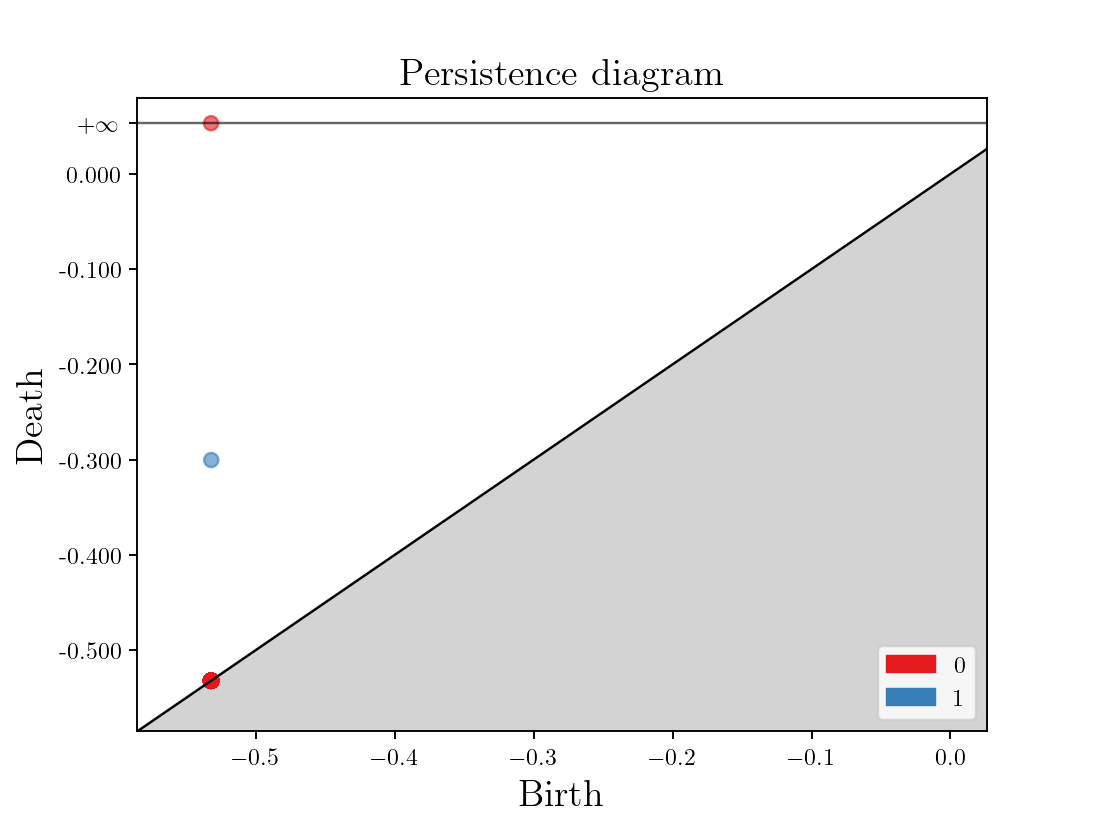

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [6]:
cplx2 = gd.CubicalComplex(top_dimensional_cells=-volcano)
diag2 = cplx2.persistence()
gd.plot_persistence_barcode(diag2)
gd.plot_persistence_diagram(diag2)

What happened to the point corresponding to the crater of the volcano between the sub- and super-levelsets?

It switched from a 0-dimensional feature (from below, we first have only the center, which is a connected component) to a 1-dimensional feature (from above, we are missing the center, that's a hole). There is some notion of duality between the two, although the hypotheses are not quite right for a true correspondence between the two diagrams.

#### 1d function
Let $f$ be the function $f: t \mapsto sin(t)+sin(2t)$

Build a table with 200 values of $f$ between 0 and $2\pi$. Plot the function, compute the persistence diagram of its sublevelsets, and draw its persistence diagram.

<IPython.core.display.Javascript object>


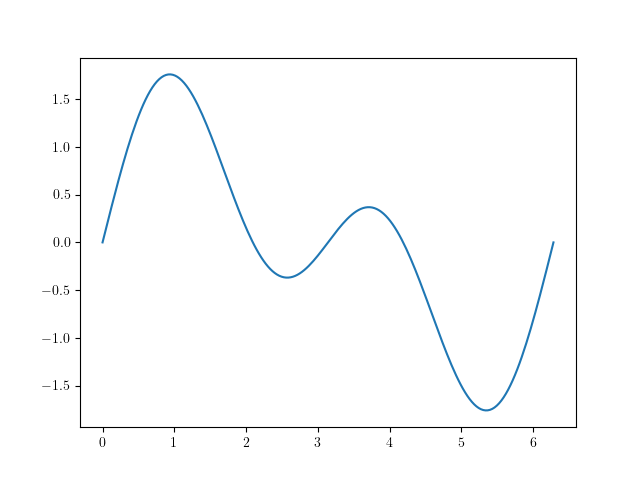

In [6]:
t = np.linspace(0, 2*np.pi, 200)
f = np.sin(t) + np.sin(2*t)
plt.figure()
plt.plot(t,f)
plt.show()

<IPython.core.display.Javascript object>


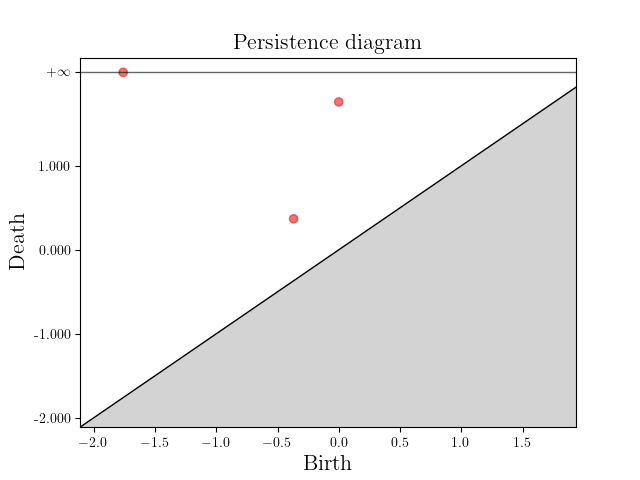

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [7]:
cplx = gd.CubicalComplex(top_dimensional_cells=f)
dgm = cplx.persistence()
gd.plot_persistence_diagram(dgm)

### 2. Point sets

Draw a set of points regularly spaced along a curve drawn on a torus. 

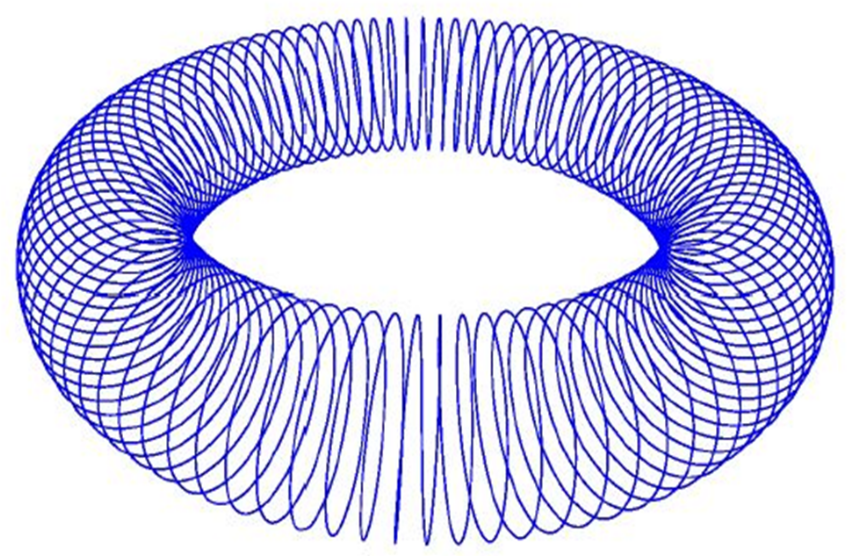

For simplicity, we embed this torus in $\mathbb{R}^4$.

<IPython.core.display.Javascript object>


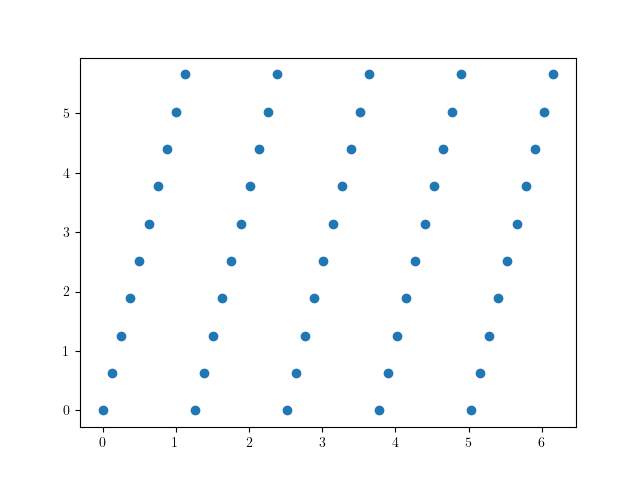

In [8]:
a = np.linspace(0, 2*np.pi, 50, False)
b = np.stack((np.cos(a),np.sin(a),np.cos(5*a),np.sin(5*a)),axis=-1)
# Plot the points on the unwrapped torus
plt.figure()
plt.scatter(a, 5*a % (2*np.pi))
plt.show()

Compute the persistence of the Čech filtration of these points. You can actually use an [$\alpha$-complex](https://gudhi.inria.fr/python/latest/alpha_complex_ref.html) for that. You should obtain the following plot.

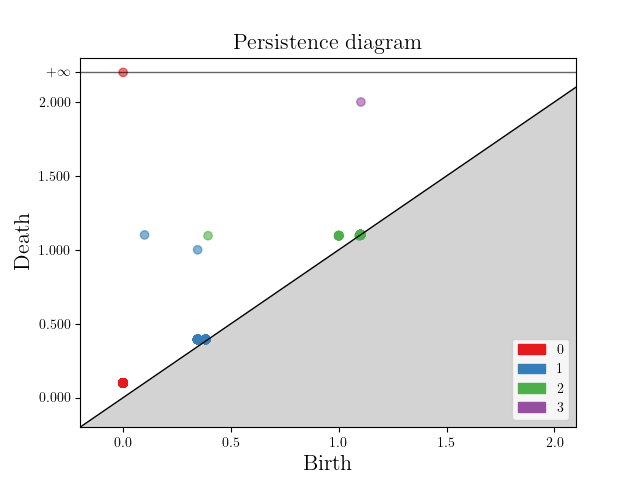

[(3, (1.102595812673837, 2.0)), (2, (0.39373133684656436, 1.095491502812549)), (1, (0.09943415215528845, 1.10063495445449)), (1, (0.34549150281252605, 1.0)), (0, (0.0, inf))]


<IPython.core.display.Javascript object>


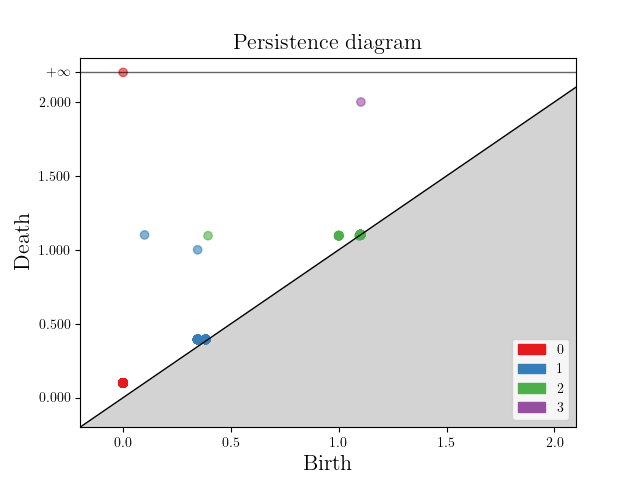

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [9]:
cplx = gd.AlphaComplex(points=b).create_simplex_tree()
p = cplx.persistence()
# print only the most persistent features
print([(dim,(birth,death)) for (dim,(birth,death)) in p if death - birth > .1])
gd.plot_persistence_diagram(p, legend=True)

Can you recognize the features of a torus here? Is there anything extra?

Among the persistent features, we see one connected component, two loops, and one 2d-hole, which corresponds to the topology of a torus. Notice that one of the loops appears significantly earlier than the other, and for a whole range of radii the union of balls centered on the points looks like a thick curve.

More surprising is the feature in dimension 3. We represented the torus as the product of the circles $x^2+y^2=1$ and $z^2+w^2=1$. This implies that all of our points lie on the 3-sphere $x^2+y^2+z^2+w^2=2$. They actually cover enough of this 3-sphere that its topology appears in the diagram.

Now do the same computation, but instead of using an $\alpha$-complex, approximate the Čech complex with a [Rips complex](https://gudhi.inria.fr/python/latest/rips_complex_ref.html). What happens if you only change the name of the class? While the $\alpha$-complex naturally has the ambient dimension, the Rips complex may be built up to an arbitrary dimension, so you need to specify a `max_dimension`. Can you still see the 3-sphere? What happens if you specify a larger dimension, say `max_dimension=5`?

<IPython.core.display.Javascript object>


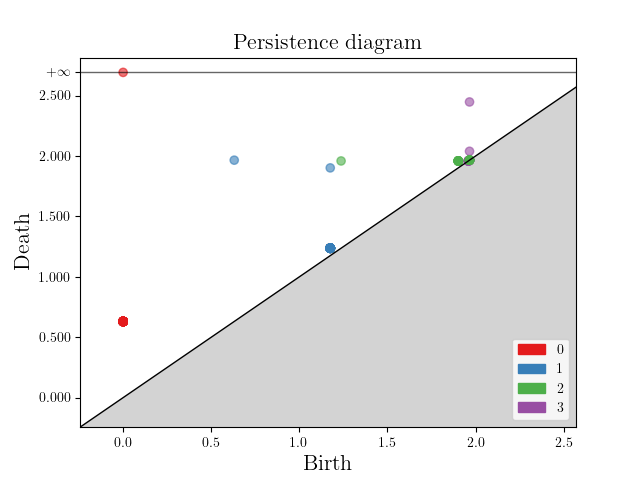

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [10]:
# Homology in dim p requires simplices in dim p+1
cplx = gd.RipsComplex(points=b).create_simplex_tree(max_dimension=4)
p = cplx.persistence()
gd.plot_persistence_diagram(p, legend=True)

With `max_dimension=5`, the program becomes quite slow and takes a lot more memory because the complex is very large. We could make it smaller by ignoring what happens for large radii (parameter `max_edge_length`), but in this case there are no interesting features in dimension 4, only noise.

### 3. Distance and stability

Let us consider again the point set on a curve on a torus in $\mathbb{R}^4$, and compute the persistence diagram of dimension 1 of its Rips filtration. Now perturb each point randomly by a small noise, and compute the persistence diagram of dimension 1 of these new points. Compute the [bottleneck distance](https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html#gudhi.bottleneck_distance) between these diagrams. Retry it a few times, maybe also with dimension 0 or 2. Can you confirm the stability result?

In [17]:
cplx = gd.RipsComplex(points=b).create_simplex_tree(2)
cplx.compute_persistence()
d1 = cplx.persistence_intervals_in_dimension(1)
# Generate random points in a small ball
epsilon = .001
l = []
while len(l) < len(b):
    pt = np.random.rand(4) * 2 - 1 # points in a square centered at origin
    if np.linalg.norm(pt) <= 1:
        l.append(pt) # Only keep the points in a ball of radius 1
noise = np.array(l) * epsilon
b_pert = b + noise
cplx_pert = gd.RipsComplex(points=b_pert).create_simplex_tree(2)
cplx_pert.compute_persistence()
d1_pert = cplx_pert.persistence_intervals_in_dimension(1)
print(gd.bottleneck_distance(d1, d1_pert))

0.0014848826964883877


The distance we get is larger than `epsilon`! But... smaller than `2*epsilon`. That's because `gudhi` uses the diameter of simplices as filtration value for Rips complexes, instead of half of the diameter.

Now do the same experiment with the $\alpha$-complex.

In [18]:
cplx = gd.AlphaComplex(points=b).create_simplex_tree()
cplx.compute_persistence()
d1a = cplx.persistence_intervals_in_dimension(1)
# Generate random points in a small ball
epsilon = .001
l = []
while len(l) < len(b):
    pt = np.random.rand(4) * 2 - 1 # points in a square centered at origin
    if np.linalg.norm(pt) <= 1:
        l.append(pt) # Only keep the points in a ball of radius 1
noise = np.array(l) * epsilon
b_pert = b + noise
cplx_pert = gd.AlphaComplex(points=b_pert).create_simplex_tree()
cplx_pert.compute_persistence()
d1a_pert = cplx_pert.persistence_intervals_in_dimension(1)
# AlphaComplex uses the square of distances, get back to true distances
d1a = np.sqrt(d1a)
d1a_pert = np.sqrt(d1a_pert)
print(gd.bottleneck_distance(d1a, d1a_pert))

0.0007911451733471075


The trap this time is that AlphaComplex uses square distances (if you are curious, this is because it also handles weights, which can make those values negative and would make the square root problematic).

## 2. Application to time series

In this second part, we are going to apply persistence computations on time series data. The main motivation behind the use of persistence for time series is that several properties of time series can be encoded in a geometric point cloud and its associated Vietoris-Rips persistence diagram through the use of *time-delay embedding* (TDE). The definition of TDE is actually quite simple: given a time series $\{x(t_1),\dots,x(t_n)\}$, and (user-defined) dimension $d\in\mathbb N^*$ and delay $T\in \mathbb N^*$, one can generate a point cloud in $\mathbb R^{d+1}$ with:

$$\begin{bmatrix}
    x(t_1) & x(t_{1+T}) & \dots  & x(t_{1+dT}) \\ 
    x(t_2) & x(t_{2+T}) & \dots  & x(t_{2+dT}) \\ 
    \vdots & \vdots     & \vdots & \vdots \\
    x(t_m) & x(t_{m+T}) & \dots  & x(t_{m+dT}) \\ 
\end{bmatrix} \in \mathbb R^{m\times d+1}$$


where $ 1 \leq m \leq n-dT$. See figure below (taken from [this article](https://aip.scitation.org/doi/10.1063/1.1531823)).

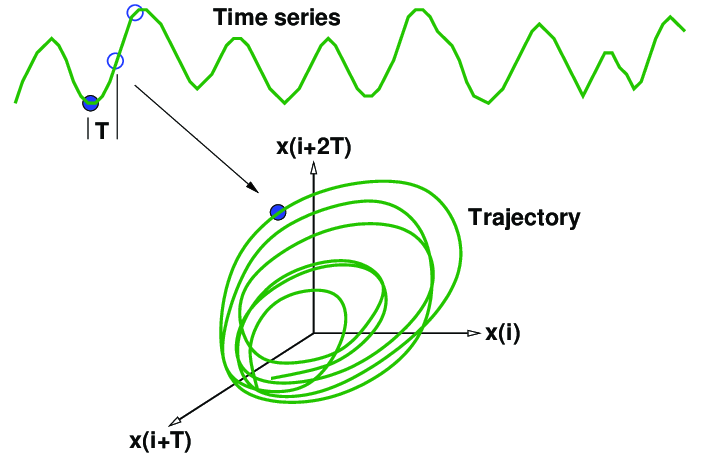

One of the very first observation is that periodicity in a time series directly translates into cycles in the associated point cloud. In order to check this, generate a simple periodic signal and visualize its TDE point cloud and Rips persistence diagram. For this, you can use the [TimeDelayEmbedding](https://gudhi.inria.fr/python/latest/point_cloud.html) function.

In [7]:
from gudhi.point_cloud.timedelay import TimeDelayEmbedding

In [8]:
xs = np.linspace(0,10*np.pi,200)

In [9]:
periodic_ts = np.cos(xs)

<IPython.core.display.Javascript object>


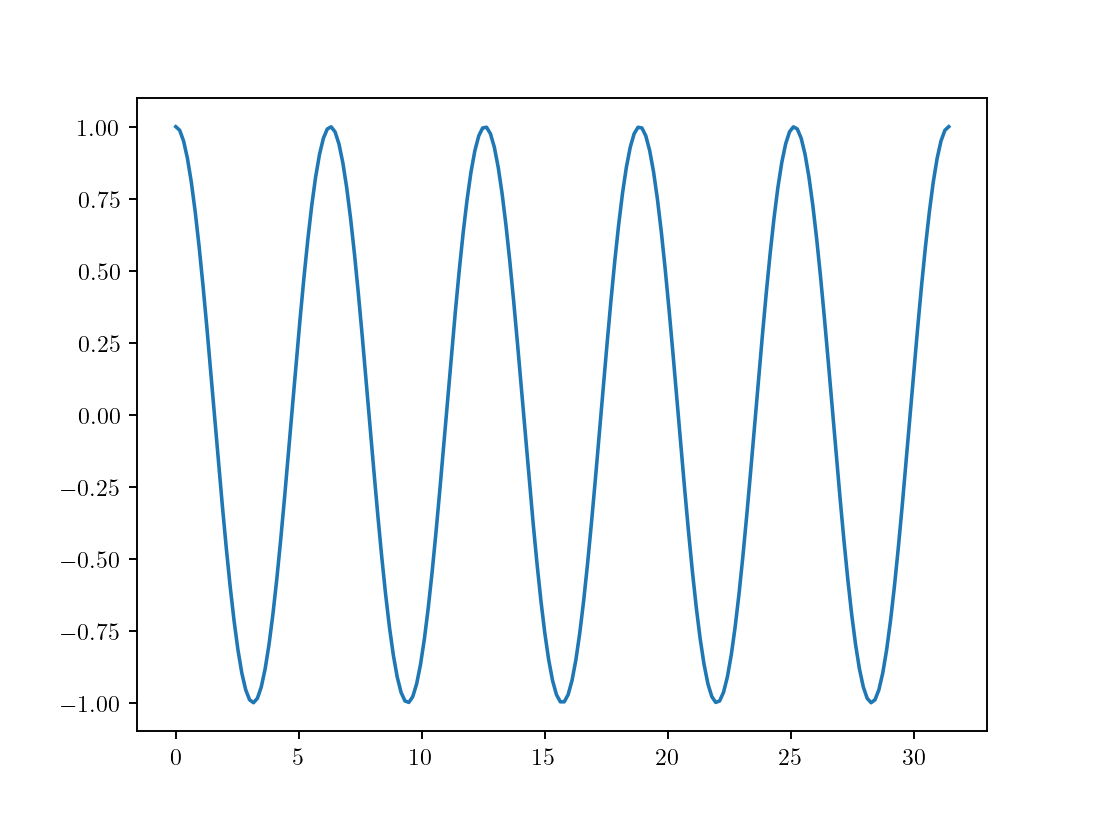

In [10]:
plt.figure()
plt.plot(xs, periodic_ts)
plt.show()

In [11]:
tde = TimeDelayEmbedding(dim=2, delay=1)
periodic_pc = tde(periodic_ts)

<IPython.core.display.Javascript object>


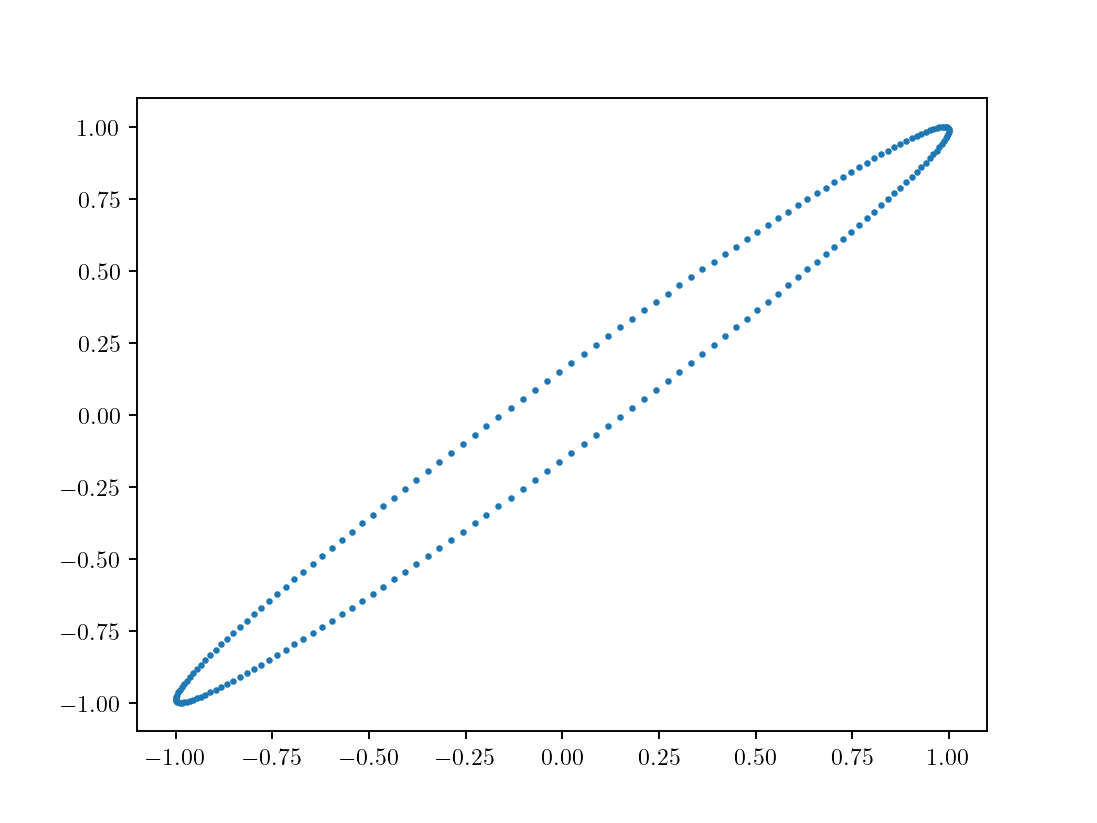

In [12]:
plt.figure()
plt.scatter(periodic_pc[:,0], periodic_pc[:,1], s=3)
plt.show()

<IPython.core.display.Javascript object>


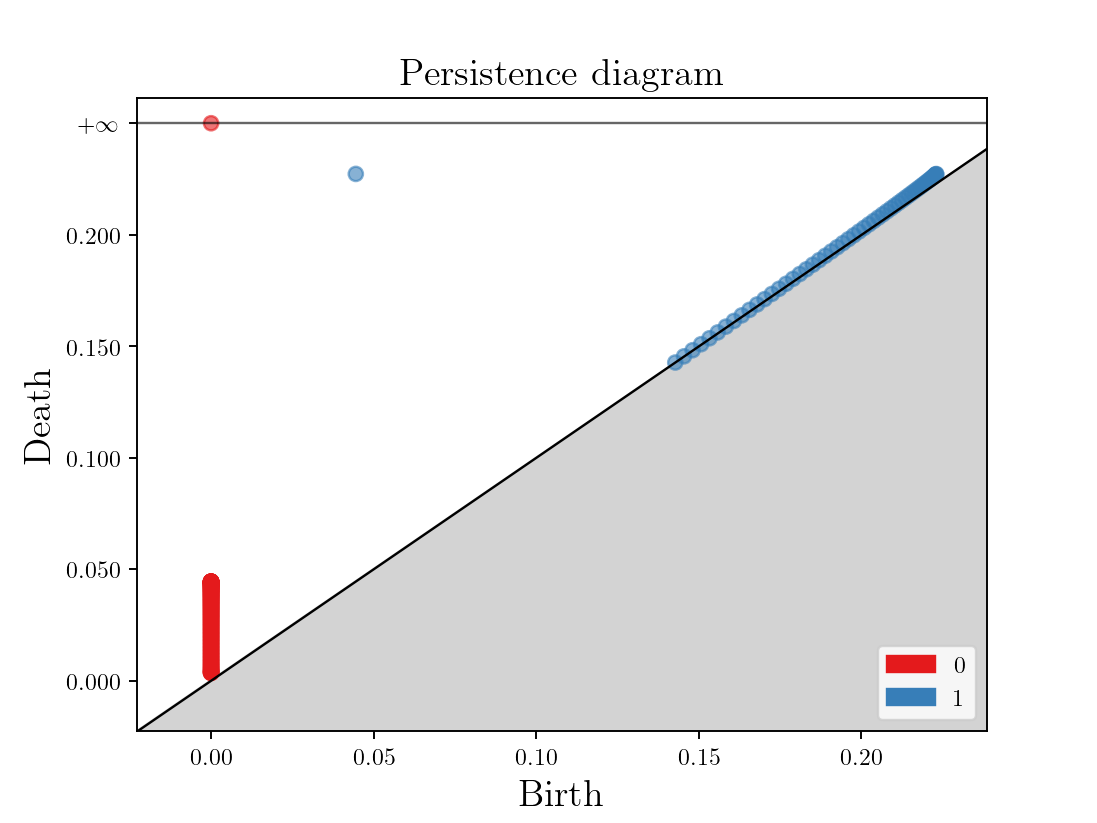

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [13]:
periodic_st = gd.RipsComplex(points=periodic_pc, max_edge_length=5).create_simplex_tree(max_dimension=2)
dgm = periodic_st.persistence()
gd.plot_persistence_diagram(dgm)

Indeed, there is one red point with infinite ordinate representing the connected component, and one blue point far away from the diagonal which represents the cycle. We captured periodicity with topology!

Another easy-to-detect time series property is shift, when the time series suddenly jumps from a range of values to another different range. Repeat the same experiment for such a phenomenon. 

In [14]:
shift_ts = np.concatenate([np.cos(5*xs)[:int(len(xs)/2)], 5+np.cos(6*xs)[int(len(xs)/2):]])

<IPython.core.display.Javascript object>


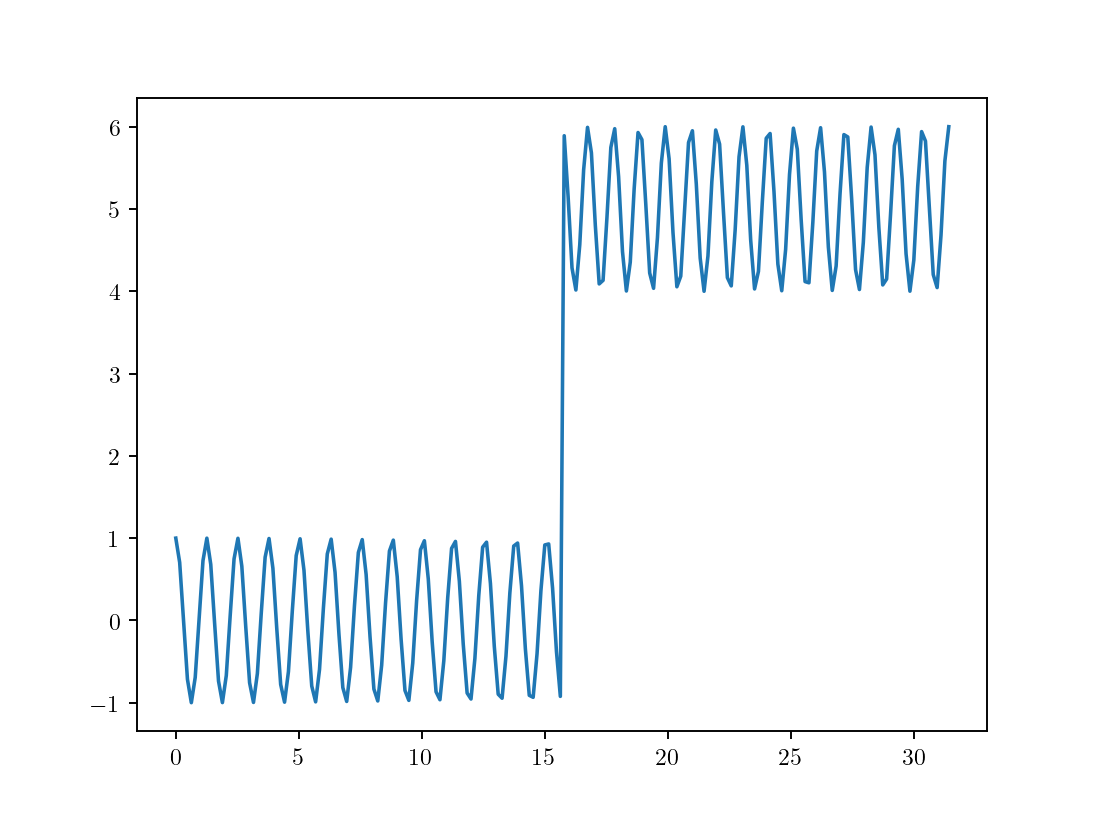

In [15]:
plt.figure()
plt.plot(xs[:500], shift_ts[:500])
plt.show()

In [16]:
tde = TimeDelayEmbedding(dim=2, delay=1)
shift_pc = tde(shift_ts)

<IPython.core.display.Javascript object>


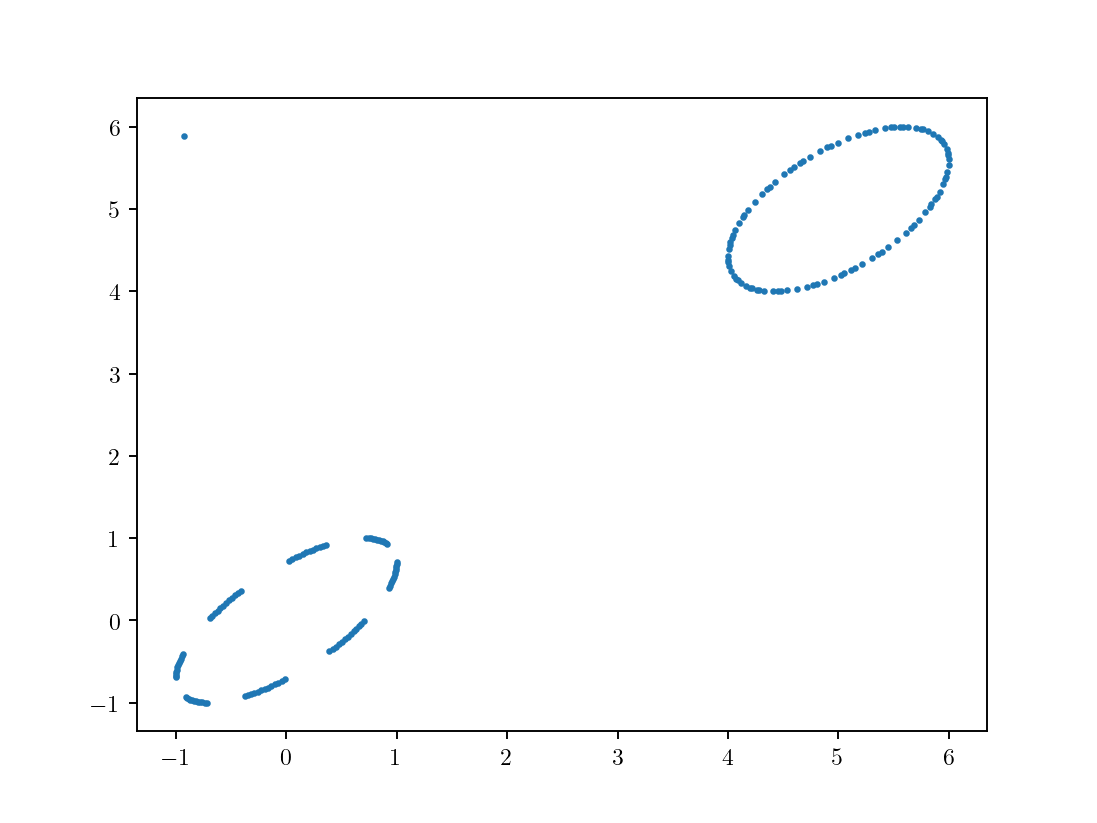

In [17]:
plt.figure()
plt.scatter(shift_pc[:,0], shift_pc[:,1], s=3)
plt.show()

This is a phenomenon that we can also capture with homology dimension 0.

<IPython.core.display.Javascript object>


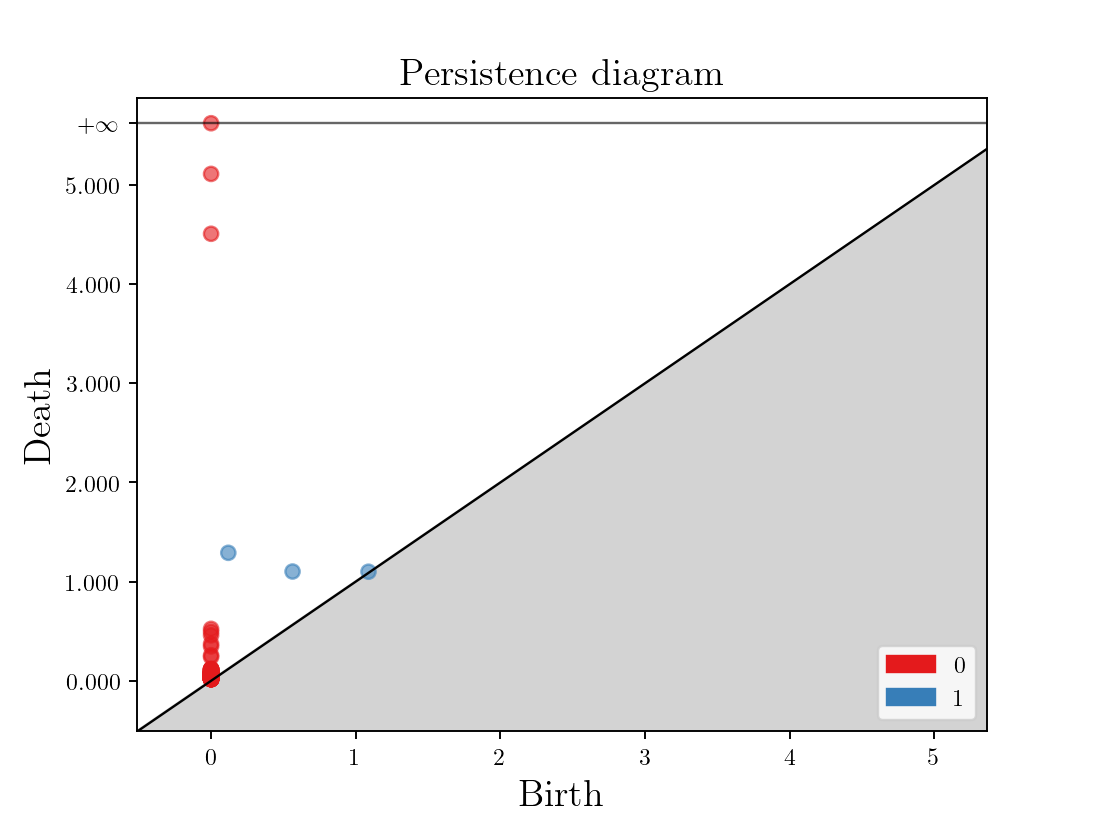

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

In [18]:
shift_st = gd.RipsComplex(points=shift_pc, max_edge_length=6).create_simplex_tree(max_dimension=2)
dgm = shift_st.persistence()
gd.plot_persistence_diagram(dgm)

Again, we have two blue points representing the two cycles, but we also have two additional red points that are far away from the diagonal, representing the new connected component and the outlier point (note that the point associated to the outlier is the highest one).

Now let's get more practical ;-) In the following, we will retrieve times series corresponding to magnetometer data of a person undergoing through four different activities, and use the corresponding persistence diagrams to classify activities with a k-nearest neighbor classifier. The data can be downloaded [here](http://www-sop.inria.fr/abs/teaching/centrale-FGMDA/slides_mathieu/activities_detection.zip).

In [21]:
path = '../../gudhi/data/activities_detection/'

In [22]:
walking = np.load(path + 'walking_p1_left_leg.npy')
stepper = np.load(path + 'stepper_p1_left_leg.npy')
cross   = np.load(path + 'cross_training_p1_left_leg.npy')
jumping = np.load(path + 'jumping_p1_left_leg.npy')

Visualize the three time series (one of each spatial coordinate) of each activity.

<IPython.core.display.Javascript object>


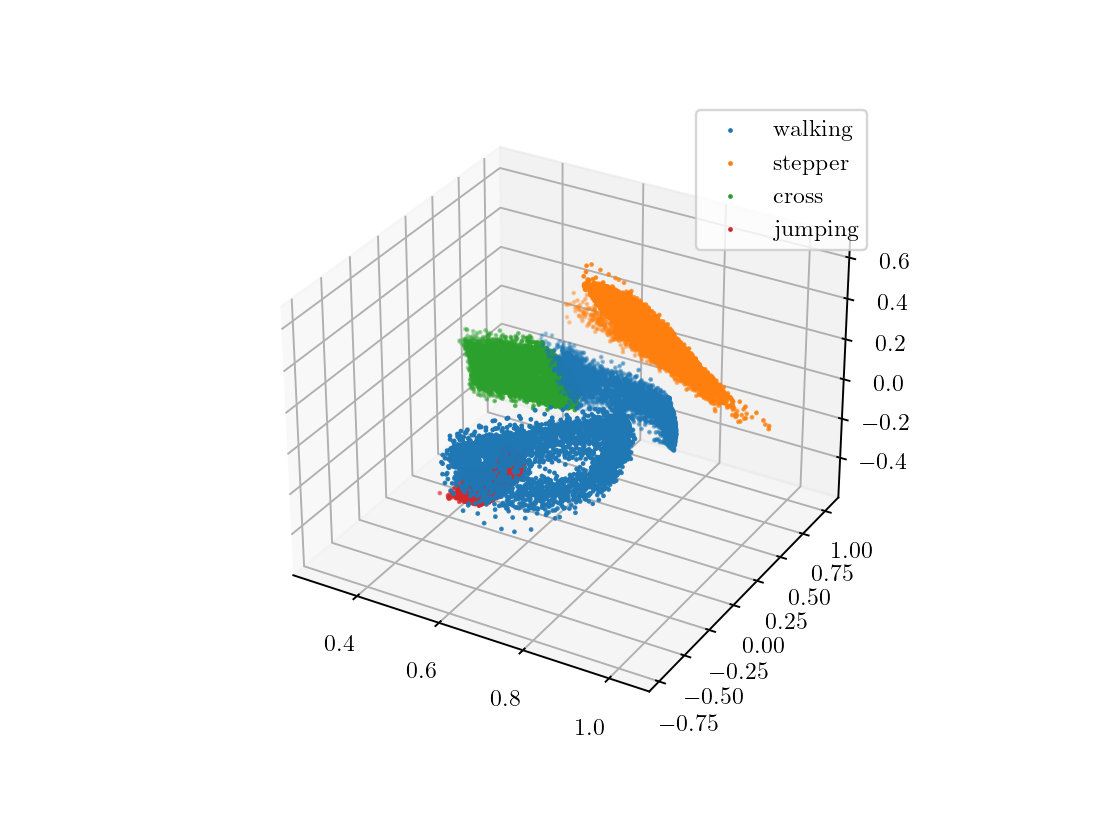

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(walking[:,0], walking[:,1], walking[:,2], s=1, label='walking')
ax.scatter(stepper[:,0], stepper[:,1], stepper[:,2], s=1, label='stepper')
ax.scatter(cross[:,0],   cross[:,1],   cross[:,2],   s=1, label='cross')
ax.scatter(jumping[:,0], jumping[:,1], jumping[:,2], s=1, label='jumping')
plt.legend()
plt.show()

Compute the four TDEs of the first spatial coordinate, randomly subsample these four point clouds 100 times to generate smaller point clouds (with only 100 points) in each activity, compute their persistence diagrams in dimension 1, and split them into train and test sets.

In [24]:
tde = TimeDelayEmbedding(dim=3, delay=1, skip=1)
walking = tde(walking[:,0])
stepper = tde(stepper[:,0])
cross   = tde(cross[:,0])
jumping = tde(jumping[:,0])

In [25]:
all_labs, all_dgms = [], []
labels = ['walking', 'stepper', 'cross', 'jumping']
for idata, data in enumerate([walking, stepper, cross, jumping]):
    n = len(data)
    list_sub_dgm = []
    for _ in range(100):
        sub_data = data[np.random.choice(n, 100, replace=True)]
        sub_simplex_tree = gd.AlphaComplex(points=sub_data).create_simplex_tree()
        sub_simplex_tree.persistence()
        sub_dgm = sub_simplex_tree.persistence_intervals_in_dimension(1)
        sub_dgm = sub_dgm[np.argwhere(~np.isinf(sub_dgm[:,1])).ravel()]
        list_sub_dgm.append(sub_dgm)
    all_dgms = all_dgms + list_sub_dgm
    all_labs = all_labs + [idata for _ in range(len(list_sub_dgm))]

In [26]:
num_pts = len(all_labs)
train_size = int(.8 * num_pts)
np.random.seed(42)
perm = np.random.permutation(num_pts)
train_idxs, test_idxs = perm[:train_size], perm[train_size:]
train_dgms = [all_dgms[itr] for itr in train_idxs]
train_labs = [all_labs[itr] for itr in train_idxs]
test_dgms = [all_dgms[ite] for ite in test_idxs]
test_labs = [all_labs[ite] for ite in test_idxs]

Use `gudhi` to compute the [bottleneck distance](https://gudhi.inria.fr/python/latest/bottleneck_distance_user.html) and different PD [representation](https://gudhi.inria.fr/python/latest/representations.html) matrices of the train and test sets. Make sure to set the parameters adequately. Representations and distance classes have API  similar to that of `Scikit-Learn`, with `fit` and `transform` methods.

In [27]:
from gudhi.representations import BottleneckDistance, WassersteinDistance

In [28]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

# Definition of pipeline
pipe = Pipeline([("Separator", gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
                 ("TDA",       gd.representations.PersistenceImage()),
                 ("Estimator", SVC())])

# Parameters of pipeline. This is the place where you specify the methods you want to use to handle diagrams
param =    [            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.PersistenceImage()], 
             "TDA__resolution":     [ [5,5], [6,6] ],
             "TDA__bandwidth":      [0.01, 0.1, 1.0, 10.0],
             "Estimator":           [SVC()]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.Landscape()], 
             "TDA__resolution":     [100],
             "Estimator":           [RandomForestClassifier()]},
           
            {"Scaler__use":         [False],
             "TDA":                 [gd.representations.BottleneckDistance()], 
             "TDA__epsilon":        [0.1], 
             "Estimator":           [KNeighborsClassifier(metric="precomputed")]}
           ]



Finally, train machine learning models on the train bottleneck distance and representations matrices, and evaluate it on your test data. How good is the accuracy score?

In [29]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipe, param, cv=3)

In [30]:
model = model.fit(train_dgms, train_labs)

In [31]:
print(model.best_params_)

{'Estimator': RandomForestClassifier(), 'Scaler__use': True, 'TDA': Landscape(), 'TDA__resolution': 100}


In [32]:
print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 1.0
Test accuracy  = 0.95
